<a href="https://colab.research.google.com/github/JuanDavid1217/Generative-AI-from-Scratch/blob/main/VAE/VAE_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import keras

input_dim=784
intermediate_dim=200
latent_dim=2

**Activation Classes**

In [ ]:
class Activation_ReLU:
  def __init__(self):
    self.input=[]
    self.output=[]
    self.dinputs=[]

  def forward(self, input):
    self.input = input
    self.output=np.maximum(0, input)

  def backward(self, dvalues):
    dvalues = np.sum(dvalues, axis=0, keepdims=True)
    self.dinputs=dvalues*np.where(self.output > 0, 1, 0)

class Activation_Sigmoid:
  def __init__(self):
    self.input=[]
    self.output=[]
    self.dinputs=[]

  def forward(self, input):
    self.output = 1 / (1 + np.exp(-input))

  def backward(self, dvalues):
    self.dinputs = dvalues * (1 - self.output) * self.output

**Clase Encoder**

In [ ]:
class Encoder:

  def __init__(self, input_dim, intermediate_dim, latent_dim):
    self.layer1=Dense(input_dim, intermediate_dim)
    self.layer1Activation=Activation_ReLU()
    self.z_mu=Dense(intermediate_dim, latent_dim)
    self.z_log_sigma2=Dense(intermediate_dim, latent_dim)
    self.z=[]

  def sample_z(self):
    epsilon = np.random.normal(0, 1, size=self.z_mu.output.shape)
    return self.z_mu.output + np.exp(self.z_log_sigma2.output*.5) * epsilon

  def encode(self, input):
    self.layer1.forward(input)
    self.layer1Activation.forward(self.layer1.output)

    self.z_mu.forward(self.layer1Activation.output)

    self.z_log_sigma2.forward(self.layer1Activation.output)

    self.z=self.sample_z();

    return self.z

**Clase Decoder**

In [ ]:
class Decoder:
  def __init__(self, latent_dim, intermediate_dim, input_dim):
    self.layer1=Dense(latent_dim, intermediate_dim)
    self.layer1Activation=Activation_ReLU()
    self.layer2=Dense(intermediate_dim, input_dim)
    self.layer2Activation=Activation_Sigmoid()

  def decode(self, input):
    self.layer1.forward(input)
    self.layer1Activation.forward(self.layer1.output)


    self.layer2.forward(self.layer1Activation.output)
    self.layer2Activation.forward(self.layer2.output)

    return self.layer2Activation.output

**Clase Dense**

In [ ]:
class Dense:
  def __init__(self, input_dim, neurons, weight_regularizer_l1=[0],
               weight_regularizer_l2=[0], bias_regularizer_l1=[0], bias_regularizer_l2=[0]):

    self.weights=0.1*np.random.randn(input_dim, neurons)
    self.biases=np.zeros((1, neurons))
    self.input=[]
    self.output=[]
    self.weight_regularizer_l1=np.array(weight_regularizer_l1)
    self.weight_regularizer_l2=np.array(weight_regularizer_l2)
    self.bias_regularizer_l1=np.array(bias_regularizer_l1)
    self.bias_regularizer_l2=np.array(bias_regularizer_l2)
    self.dweights=0
    self.dbiases=0
    self.dinputs=0

  def  forward(self, input):
    self.input=input
    self.output=np.dot(self.input, self.weights)+self.biases

  def backward(self, dvalues):
    self.dweights = np.dot(self.input.T, dvalues)
    self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

    if self.weight_regularizer_l1.any()>0:
      dL1=np.ones_like(self.weights)
      dL1[self.weights<0]=-1
      self.dweights += np.squeeze(self.weight_regularizer_l1 * dL1, axis=0)

    if self.weight_regularizer_l2.any()>0:
      self.dweights += 2 * np.squeeze(self.weight_regularizer_l2 * \
                       self.weights, axis=0)

    if self.bias_regularizer_l1.any() > 0:
      dL1 = np.ones_like(self.biases)
      dL1[self.biases < 0] = -1
      self.dbiases += self.bias_regularizer_l1 * dL1

    if self.bias_regularizer_l2.any() > 0:
      self.dbiases += 2 * self.bias_regularizer_l2 * \
                      self.biases

    self.dinputs = np.dot(dvalues, self.weights.T)

  def backward2(self, dvalues):
      self.dbiases=dvalues
      if self.input.shape[0]!=1:
         self.input=self.input.reshape(1, -1)
      self.dweights=np.dot(self.input.T,dvalues)
      self.dinputs=np.dot(dvalues, self.weights.T)



**Perdidas**

In [ ]:
class Loss:
  def __init__(self):
    self.accumulated_sum=0
    self.accumulated_count=0

  def regularization_loss(self):
    regularization_loss = 0
    count=1
    for layer in self.trainable_layers:
      print(count)
      count+=1
      if layer.weight_regularizer_l1.any()>0:
        print("wrl1: ", layer.weight_regularizer_l1.shape)
        print("w: ", layer.weights.shape)
        regularization_loss += layer.weight_regularizer_l1 * \
                              np.sum(np.abs(layer.weights))
        print("rl: ", regularization_loss.shape)
      if layer.weight_regularizer_l2.any() > 0:
        regularization_loss += layer.weight_regularizer_l2 * \
                              np.sum(layer.weights * \
                                      layer.weights)

      if layer.bias_regularizer_l1.any() > 0:
        regularization_loss += layer.bias_regularizer_l1 * \
                              np.sum(np.abs(layer.biases))

      if layer.bias_regularizer_l2.any() > 0:
        regularization_loss += layer.bias_regularizer_l2 * \
                              np.sum(layer.biases * \
                                      layer.biases)
    return regularization_loss

  def remember_trainable_layers(self, trainable_layers):
    self.trainable_layers=trainable_layers

  def calculate(self, output, y, *, include_regularization = False):
    sample_losses=self.forward(output, y)
    data_loss = np.mean(sample_losses)

    self.accumulated_sum += np.sum(sample_losses)
    self.accumulated_count += len(sample_losses)

    if not include_regularization:
      return data_loss
    else:
      return data_loss, self.regularization_loss()

  def calculate_accumulated(self, *, include_regularization = False):
    data_loss = self.accumulated_sum / self.accumulated_count

    if not include_regularization:
      return data_loss
    else:
      return data_loss, self.regularization_loss()

  def new_pass(self):
    self.accumulated_sum = 0
    self.accumulated_count = 0

class LossBinaryCrossEntropy(Loss):
  def forward(self, y_pred, y_true):
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

    sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
    #sample_losses = np.mean(sample_losses, axis=1)

    return sample_losses

  def backward(self, dvalues, y_true):
    samples = len(dvalues)
    outputs = len(dvalues[0])

    clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

    self.dinputs = -(y_true / clipped_dvalues - (1 - y_true)
                     /(1 - clipped_dvalues))/outputs

    self.dinputs = self.dinputs / samples


**Optimizador rmsprop**

In [ ]:
class Rmsprop:
  def __init__(self, learning_rate=0.0006, decay=0., epsilon=1e-8, rho=0.9):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.rho = rho

  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * \
          (1. / (1. + self.decay * self.iterations))

  def update_params(self, layer):
    if not hasattr(layer, 'wight_cache'):
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_cache = np.zeros_like(layer.biases)

    layer.weight_cache = self.rho * layer.weight_cache + \
        (1 - self.rho) * layer.dweights**2
    layer.bias_cache = self.rho * layer.bias_cache + \
        (1 - self.rho) * layer.dbiases**2

    layer.weights += -self.current_learning_rate * \
                    layer.dweights / \
                    (np.sqrt(layer.weight_cache) + self.epsilon)
    layer.biases += -self.current_learning_rate * \
                    layer.dbiases / \
                    (np.sqrt(layer.bias_cache) + self.epsilon)
    return layer

  def post_update_params(self):
    self.iterations += 1


**Optimizador Adam**

In [ ]:
class Optimizer_Adam:
  def __init__(self, learning_rate=0.01, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.beta_1 = beta_1
    self.beta_2 = beta_2


  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

  def update_params(self, layer):
    if not hasattr(layer, 'weight_cache'):
      layer.weight_momentums = np.zeros_like(layer.weights)
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_momentums = np.zeros_like(layer.biases)
      layer.bias_cache = np.zeros_like(layer.biases)

    # Update momentum with current gradients
    layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
    layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
    # Get corrected momentum
    # self.iteration is 0 at first pass
    # and we need to start with 1 here
    weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
    bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
    # Update cache with squared current gradients
    layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
    layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
    # Get corrected cache
    weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
    bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
    # Vanilla SGD parameter update + normalization
    # with square rooted cache
    layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
    layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

  # Call once after any parameter updates
  def post_update_params(self):
    self.iterations += 1

**Importación del Dataset**

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype( 'float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape( (len(x_test),  np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
count0=0
count1=0
count2=0
new_train=[]
for i in range(len(y_train)):
    if y_train[i]==5:
      if count0<10:
        new_train.append(x_train[i])
        count0+=1
    elif y_train[i]==0:
      if count1<10:
        new_train.append(x_train[i])
        count1+=1
    elif y_train[i]==4:
      if count2<10:
        new_train.append(x_train[i])
        count2+=1



In [ ]:
new_test=[x_test[3], x_test[15], x_test[6]]

**Clase VAE**

In [ ]:
class VAE:
  def __init__(self, input_dim, intermediate_dim, latent_dim):
    self.encoder=Encoder(input_dim, intermediate_dim, latent_dim)
    self.decoder=Decoder(latent_dim, intermediate_dim, input_dim)
    self.optimizer=Rmsprop()
    self.binaryCrossEntropy=LossBinaryCrossEntropy()
    self.trainable_layers=[self.encoder.layer1, self.encoder.z_mu, self.encoder.z_log_sigma2,\
                        self.decoder.layer1, self.decoder.layer2]

    self.binaryCrossEntropy.remember_trainable_layers(self.trainable_layers)


  def predict(self, input):
    return self.decoder.decode(self.encoder.encode(input))

  #Funcio de perdida ELBO
  def ELBO(self, input, output):
      logP = len(input)*self.binaryCrossEntropy.forward(output, input)
    #D(Q(z|x)||P(z))
      Dk1 = 0.5 * np.sum(np.exp(self.encoder.z_log_sigma2.output)+np.square(self.encoder.z_mu.output)-1. - self.encoder.z_log_sigma2.output, axis=-1)
      logP=np.mean(logP)
      return np.mean(logP+Dk1)

  def backward(self, input, output):
    loss=(output-input)
    self.decoder.layer2Activation.backward(loss)
    self.decoder.layer2.backward2(self.decoder.layer2Activation.dinputs)
    self.decoder.layer1Activation.backward(self.decoder.layer2.dinputs)
    self.decoder.layer1.backward2(self.decoder.layer1Activation.dinputs)
    self.encoder.z_log_sigma2.backward2(self.decoder.layer1.dinputs)
    self.encoder.z_mu.backward2(self.decoder.layer1.dinputs)
    self.encoder.layer1Activation.backward(self.encoder.z_mu.dinputs)
    self.encoder.layer1.backward2(self.encoder.layer1Activation.dinputs)
    self.binaryCrossEntropy.backward(self.encoder.layer1.dinputs,input)


  def fit(self, input, epochs=1, batch_size=None, validation_data=None):
    for epoch in range(1, epochs+1):
      print("Epoch: ", epoch)
      loss=0
      self.binaryCrossEntropy.new_pass()
      for data in input:
        output=self.predict(data)
        loss += self.ELBO(data, output)
        self.backward(data, output)
        self.optimizer.pre_update_params()
        for layer in self.trainable_layers:
          layer=self.optimizer.update_params(layer)
        self.optimizer.post_update_params()
      print("Loss: ", loss/len(input))
    print("train end")


**Pruebas durante realización**

In [ ]:
import matplotlib.pyplot as plt
modelVAE=VAE(input_dim, intermediate_dim, latent_dim)
modelVAE.fit(input=x_train[0:5], epochs=500, batch_size=None, validation_data=None)

Epoch:  1
Loss:  540.0276361792859
Epoch:  2
Loss:  489.15381445862187
Epoch:  3
Loss:  369.46715267828193
Epoch:  4
Loss:  299.9905880972845
Epoch:  5
Loss:  294.755399067897
Epoch:  6
Loss:  251.46236888384146
Epoch:  7
Loss:  221.14596686929673
Epoch:  8
Loss:  220.2068847712736
Epoch:  9
Loss:  214.3838921251907
Epoch:  10
Loss:  212.46921315260116
Epoch:  11
Loss:  198.9553178170758
Epoch:  12
Loss:  212.80349755304783
Epoch:  13
Loss:  191.45311981813958
Epoch:  14
Loss:  191.39529761545444
Epoch:  15
Loss:  185.58643581440703
Epoch:  16
Loss:  186.99177665091005
Epoch:  17
Loss:  181.9124105865023
Epoch:  18
Loss:  188.02842080390172
Epoch:  19
Loss:  198.09769354375345
Epoch:  20
Loss:  169.27061943638955
Epoch:  21
Loss:  179.0096820932233
Epoch:  22
Loss:  172.55983842145017
Epoch:  23
Loss:  170.60254368857676
Epoch:  24
Loss:  169.4175090504977
Epoch:  25
Loss:  161.10630988360205
Epoch:  26
Loss:  157.97887581457636
Epoch:  27
Loss:  160.02842473793658
Epoch:  28
Loss:  15

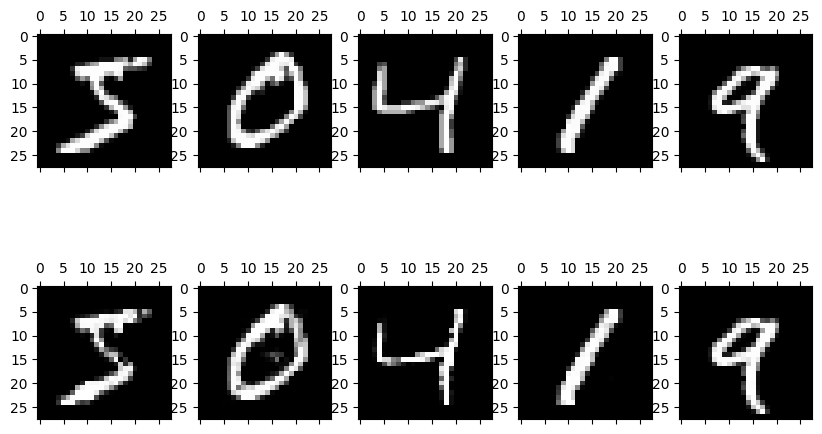

In [ ]:
fig, ax = plt.subplots(2,5, figsize = (10, 6))

for i in range(len(x_train[0:5])): #Probamos con 3 imagenes del congunto de test
    img=x_train[i][None,:]
    out_img = modelVAE.predict(img)
    ax[0,i].matshow(img.reshape((28,28)),  cmap='gray', clim=(0,1))
    ax[1,i].matshow(out_img.reshape((28,28)), cmap='gray', clim=(0,1))
pass

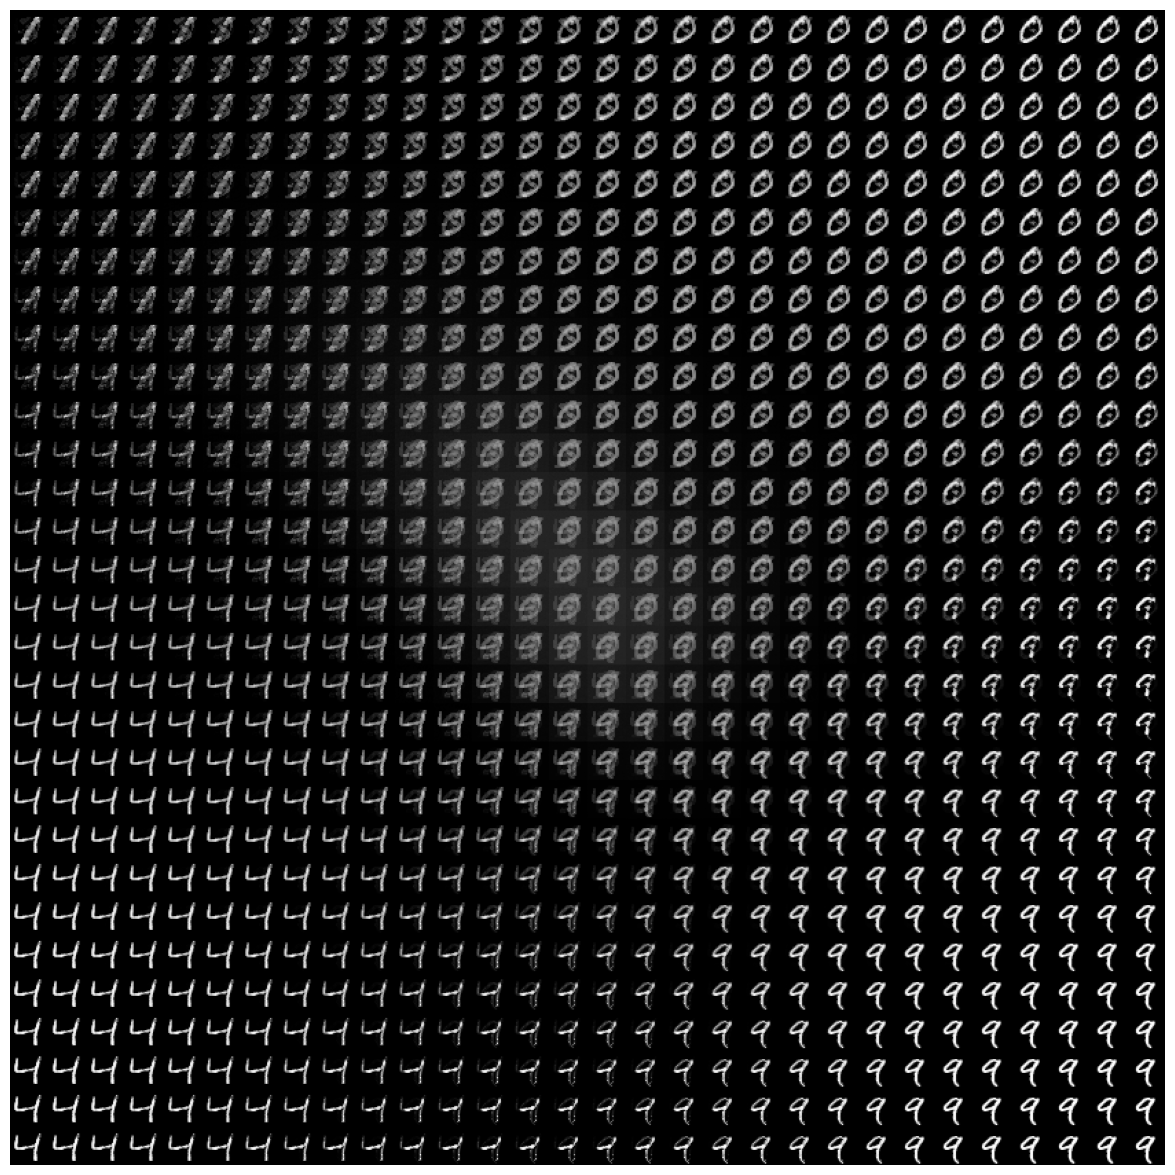

In [ ]:
numImgs = 30
newrows,newcols=28,28
lo, hi  = -3.,3.

z1 = np.linspace(lo, hi, numImgs)
z2 = np.linspace(lo, hi, numImgs)

import matplotlib.pyplot as plt

plt.figure(figsize=(15,15*newcols/newrows))
canvas=np.zeros((newrows*numImgs,newcols*numImgs))
for i in range(numImgs):
    for j in range(numImgs):
        z=np.array([z1[i], z2[j] ])
        z=np.expand_dims(z, axis=0)
        Im=modelVAE.decoder.decode(z)
        canvas[newrows*i:newrows*(i+1), newcols*j:newcols*(j+1)] = Im.reshape((newrows,newcols))

plt.imshow(canvas, 'gray')
plt.axis('off')
plt.show()

Prueba con el dataset de estrellas

In [ ]:
!git clone https://github.com/FaustineLi/Variational-Autoencoders.git

Cloning into 'Variational-Autoencoders'...
remote: Enumerating objects: 247, done.
remote: Total 247 (delta 0), reused 0 (delta 0), pack-reused 247
Receiving objects: 100% (247/247), 24.04 MiB | 20.52 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [ ]:
cd /content


/content


In [ ]:
cd Variational-Autoencoders/

/content/Variational-Autoencoders


In [ ]:
import scipy.io
sil = scipy.io.loadmat('./resources/data/caltech101_16.mat')
silX = sil['X']
silY = sil['Y']
silX_train = silX[np.where(sil['Y'] == 87)[1],:][0:80,:]
silX_test  = silX[np.where(sil['Y'] == 87)[1],:][81:,:]

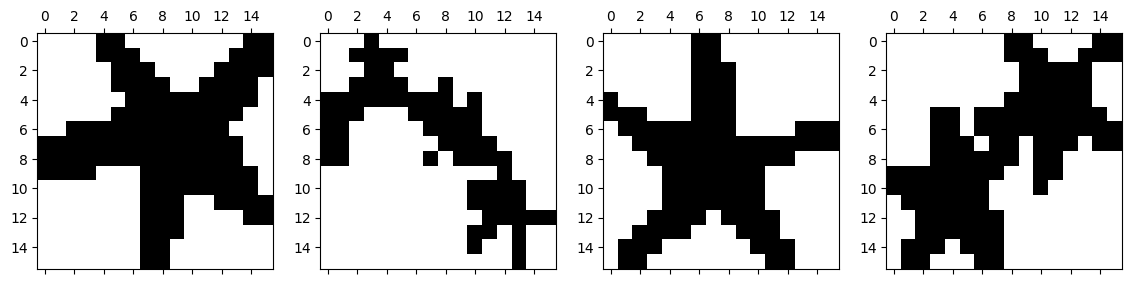

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (14, 10))
for i in range(4):
    ax[i].matshow(silX_train[i].reshape((16,16)), cmap='gray', clim=(0,1))
pass

In [ ]:
sinput_dim=256
sintermediate_dim=100
slatent_dim=2

In [ ]:
modelStar=VAE(sinput_dim, sintermediate_dim, slatent_dim)
modelStar.fit(input=silX_train[0:3], epochs=80, batch_size=None, validation_data=None)

Epoch:  1
Loss:  178.48713964011188
Epoch:  2
Loss:  180.04068978154564
Epoch:  3
Loss:  173.88007749792988
Epoch:  4
Loss:  189.29250646270933
Epoch:  5
Loss:  197.75087370750876
Epoch:  6
Loss:  188.7614483830565
Epoch:  7
Loss:  172.94083844662748
Epoch:  8
Loss:  216.10973600498923
Epoch:  9
Loss:  239.03780643918785
Epoch:  10
Loss:  359.290065426176
Epoch:  11
Loss:  508.756971761364
Epoch:  12
Loss:  440.10677217979816
Epoch:  13
Loss:  199.918517714197
Epoch:  14
Loss:  182.5234201512625
Epoch:  15
Loss:  148.45233325492796
Epoch:  16
Loss:  132.8084760349458
Epoch:  17
Loss:  118.11449572694363
Epoch:  18
Loss:  114.22265794475082
Epoch:  19
Loss:  125.18039788942934
Epoch:  20
Loss:  102.13468304634739
Epoch:  21
Loss:  106.32676139106007
Epoch:  22
Loss:  92.66583186066335
Epoch:  23
Loss:  113.18052198531292
Epoch:  24
Loss:  95.67164799939435
Epoch:  25
Loss:  100.37979923550076
Epoch:  26
Loss:  110.3603380076704
Epoch:  27
Loss:  100.5227632152081
Epoch:  28
Loss:  102.6

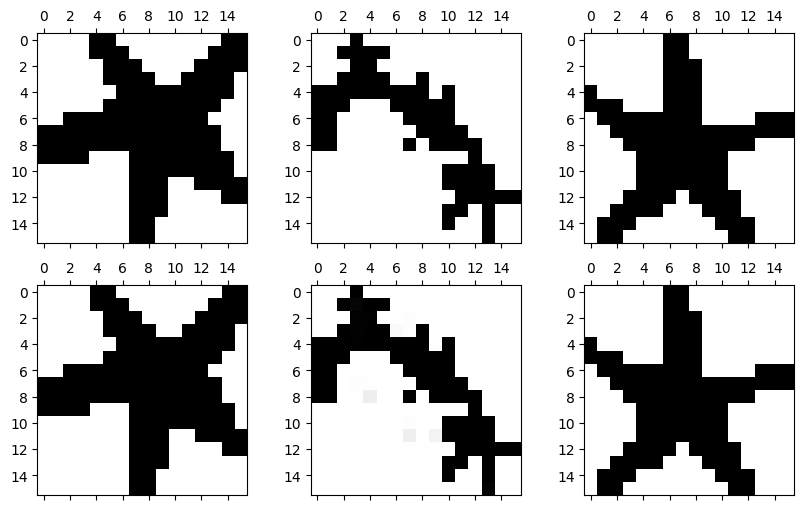

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (10, 6))

for i in range(len(silX_train[0:3])): #Probamos con 3 imagenes del congunto de test
    img=silX_train[i]
    out_img = modelStar.predict(img)
    ax[0,i].matshow(img.reshape((16,16)),  cmap='gray', clim=(0,1))
    ax[1,i].matshow(out_img.reshape((16,16)), cmap='gray', clim=(0,1))
pass

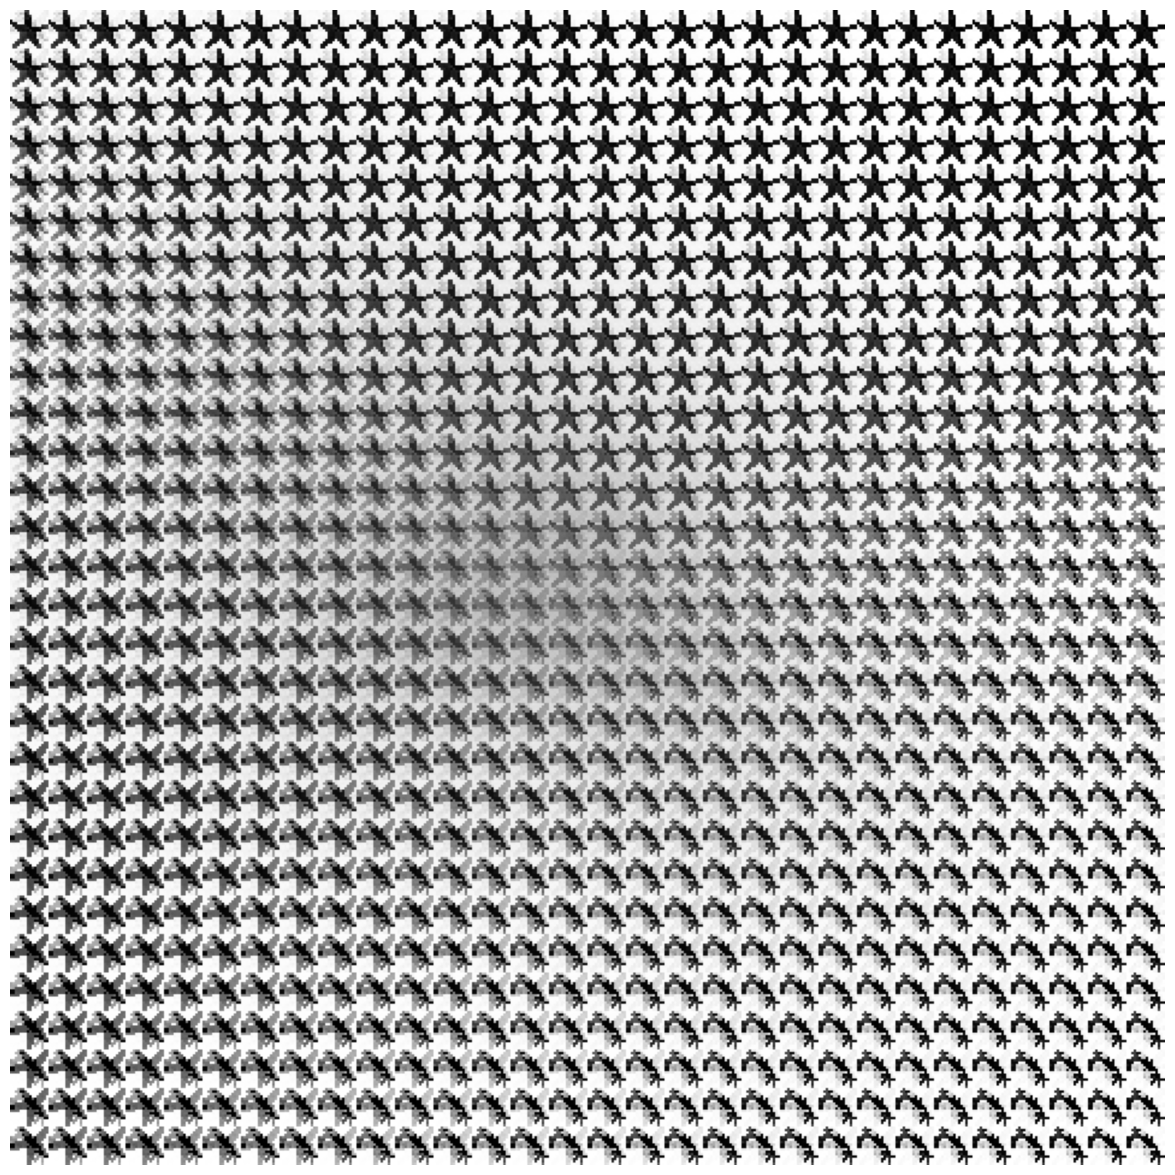

In [ ]:
numImgs = 30
newrows,newcols=16,16
lo, hi  = -3.,3.

z1 = np.linspace(lo, hi, numImgs)
z2 = np.linspace(lo, hi, numImgs)

import matplotlib.pyplot as plt

plt.figure(figsize=(15,15*newcols/newrows))
canvas=np.zeros((newrows*numImgs,newcols*numImgs))
for i in range(numImgs):
    for j in range(numImgs):
        z=np.array([z1[i], z2[j] ])
        z=np.expand_dims(z, axis=0)
        Im=modelStar.decoder.decode(z)
        canvas[newrows*i:newrows*(i+1), newcols*j:newcols*(j+1)] = Im.reshape((newrows,newcols))

plt.imshow(canvas, 'gray')
plt.axis('off')
plt.show()